# Tutorial: Tabular classification model with fastai2



Tabular modelling takes data in the form of a table (like a spreadsheet or CSV--comma separated values). The objective is to predict the value in one or more columns, based on the values in the other columns.

A classification model is one which attempts to predict a class, or category. That is, it's predicting from a number of discrete possibilities, such as \"dog\" or \"cat.\"

In this tutorial, we'll be looking at the so-called dataset ["Adult" dataset](https://archive.ics.uci.edu/ml/datasets/Adult), also known as "Census Income" dataset. The task is to predict whether income exceeds $50K/yr based on census data.. This tutorial is based on selected contents from these two notebooks:
* https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb
* https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Tabular%20Notebooks/01_Adults.ipynb

This tutorial can then be used as starting point for the task of predicting the dynamical index of space debris motions.

## Setup the GPU

Before starting, you will need to set colab to use the GPU:
* Go to Edit > Notebook settings or Runtime > Change runtime type and select GPU as Hardware accelerator.
* https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d

## Install Fastai2 library

The fastai2 library is not pre-installed in colab so we first need to pip install it. Using "!" at the beginning of a cell in a Jupyter notebook runs a shell command inside the notebook, and installs the library directly to the colab virtual machine. You only need to rerun this when restarting the kernel.

In [1]:
!pip install -q fastai2

     |████████████████████████████████| 194kB 6.2MB/s 


In fastai2, all the modules related to tabular learning can be found under *fastai.tabular.all*.


In [0]:
from fastai2.tabular.all import *

We'll need to do some tabular data processing and querying, so we'll want to use the Pandas library. Finally, we'll also need numpy, since that's the main numeric programming library that Pandas rely on.


In [0]:
import numpy as np
import pandas as pd

## Download & Access Data

A small fragment of the adults dataset is available in the fastai library under the url *ADULT_SAMPLE*

In [0]:
from fastai2.data.all import *

In [5]:
path = untar_data(URLs.ADULT_SAMPLE)

In [6]:
path.ls()

(#3) [Path('/root/.fastai/data/adult_sample/export.pkl'),Path('/root/.fastai/data/adult_sample/models'),Path('/root/.fastai/data/adult_sample/adult.csv')]

The data we want lives in `adult.csv`

In [0]:
df = pd.read_csv(path/'adult.csv')

Let's take a look at it:

In [8]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


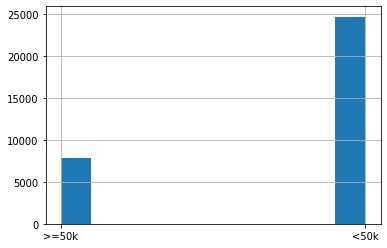

In [9]:
df['salary'].hist()

In [10]:
class_counts = np.unique(df['salary'], return_counts=True)
class_counts[0], class_counts[1], class_counts[1]/len(df)

(array(['<50k', '>=50k'], dtype=object),
 array([24720,  7841]),
 array([0.75919044, 0.24080956]))

## Preprocess Data

We'll create two tabular dataloaders (for training and validation respectively) from a single dataframe in `fastai2` using the call `TabularDataLoaders.from_df`. It expects some dataframe, some `procs`, `cat_names`, `cont_names`, `y_names`, `y_block`, and some splits. We'll walk through all of them

First we need to grab our categorical and continuous variables, along with how we want to process our data. Since the aim of this tutorial is to be transfered to the space debris motion dataset, which only contains continuos variables, we will only add the `cont_names` from the dataset.

In [0]:
cat_names = [] # This is omitted in this tutorial
cont_names = ['age', 'fnlwgt', 'education-num']

In [0]:
dep_var = 'salary'

Instead of doing a random 80%-20% splitting of the original dataset, here we want to ensure that **the proportion of classes between train/valid datasets is the same**. This is specially useful in class imbalanced problems. This is known in ML as *stratification*. 

In [13]:
splitter = TrainTestSplitter(test_size=0.2, stratify=df['salary'])
splits = splitter(range_of(df))
[len(x) for x in splits] # 0 is training, 1 is validation

[26048, 6513]

In [0]:
dls = TabularDataLoaders.from_df(df=df, 
                           procs=[FillMissing(add_col=False), Normalize], 
                           cont_names=cont_names, 
                           y_names=dep_var, 
                           y_block=CategoryBlock(vocab=['<50k','>=50k']), 
                           valid_idx=splits[1],
                           bs=1024) # Be careful when copying this bs into your own dataset

In [15]:
dls.train.n, dls.valid.n

(26048, 6513)

In [16]:
dls.cont_names

(#3) ['age','fnlwgt','education-num']

The other important piece of information that we have to tell fastai is how to get the dependent variables from the dataset (the `ys`). For that purpose you use the argument `y_names`. The argument `y_block` specifies the type of ML task we are interestied in (in this case, classification, so we use a `CategoryBlock`).

In [17]:
dls.vocab

(#2) ['<50k','>=50k']

In [18]:
dls.ys

,salary
0,1
1,1
2,0
3,1
4,0
...,...
32556,1
32557,0
32558,1
32559,0


A neural network cares about normalization of the input data. Therefore, we add the Normalize *processor* when we build our `TabularDataLoaders`. A `processor` transform the data auomatically for training.

In [19]:
dls.procs

Pipeline: FillMissing -> Categorize -> Normalize

In deep learning, we don't feed the model one item at a time but several of them (what we call a *mini-batch*, or just a *batch*). To group them in a big array (usually called a tensor) that is going to go through our model, they all need to be of the same size. DataLoader is a class that provides batches of a few items at a time to the GPU. When you loop through a DataLoader fastai will give you 64 (default batch size `bs`) items at a time, all stacked up into a single tensor. Tabular models and data don't generally require much GPU RAM, so we can use larger batch sizes. We can take a look at a few of those items by calling the `show_batch` method on a DataLoader. Note that the `DataLoaders` object `dls` includes validation and training DataLoaders. 

In [20]:
dls.valid.show_batch()

,age,fnlwgt,education-num,salary
0,65.0,325089.0,6.0,<50k
1,60.0,152369.0,11.0,<50k
2,37.0,233490.0,9.0,<50k
3,52.0,189728.0,9.0,<50k
4,20.0,219262.0,10.0,<50k
5,60.0,173960.0,10.0,<50k
6,55.0,116878.0,16.0,>=50k
7,46.0,377622.0,9.0,<50k
8,51.0,106257.0,12.0,<50k
9,31.0,308540.0,10.0,>=50k


## Training a Model

First we set up a `tabular_learner`, and what data we want to train it on.

In [0]:
learn = tabular_learner(dls, loss_func=CrossEntropyLossFlat(), metrics=[accuracy])

In order to define how well a model does on a single prediction, we need to define a loss function, which determines how we score a prediction as good or bad. We set the loss function to Cross Entropy loss (also called logistic loss), an standard in classification problems.

In [0]:
??learn.loss_func

![](https://i.imgur.com/12DWl7H.png)

We can take a look at the default architecture created for our tabular regression model. You can change the number of size of the linear layers when creating the learner (passing your own array as the argument `layers`).

In [35]:
learn.summary()

TabularModel (Input shape: ['1024 x 0', '1024 x 3'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          1024 x 3             6          True      
________________________________________________________________
BatchNorm1d          1024 x 3             6          True      
________________________________________________________________
Linear               1024 x 200           600        True      
________________________________________________________________
ReLU                 1024 x 200           0          False     
________________________________________________________________
BatchNorm1d          1024 x 200           400        True      
________________________________________________________________
Linear               1024 x 100           20,000     True      
________________________________________________________________
ReLU                 1024 x 100           0          False     
_____________________________________________

Find a suitable learning rate through `lr_find`. For more information about this method go to the tutorial of Tuesday's LTW-I project `AI_navigation`.

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.0006918309954926372)

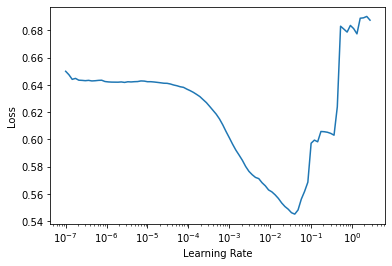

In [36]:
learn.lr_find()

To fit the architecture to the data, we use `fit_one_cycle`, the most commonly used method for training fastai models from scratch (i.e. without transfer learning):

epoch,train_loss,valid_loss,accuracy,time
0,0.493079,0.456007,0.779057,00:00
1,0.460980,0.443096,0.782589,00:00
2,0.449638,0.442015,0.786734,00:00
3,0.443698,0.440185,0.787502,00:00
4,0.439813,0.439498,0.789191,00:00


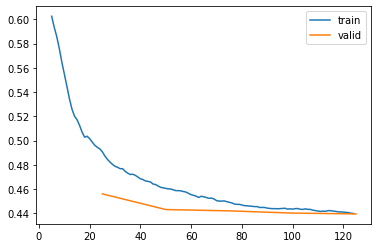

In [37]:
learn.fit_one_cycle(n_epoch=5, lr_max=5e-3)
learn.recorder.plot_loss()

Deciding how to change our parameters based on the values of the gradients is an important part of the deep learning process. Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the learning rate (lr). The learning rate is often a number between 0.001 and 0.1, although it could be anything. Often, people select a learning rate just by trying a few, and finding which results in the best model after training (we'll show you more about this in tomorrow's project). If you pick a learning rate that's too low, it can mean having to do a lot of steps. But picking a learning rate that's too high is even worse--it can actually result in the loss getting worse.

In [38]:
learn.show_results()

,age,fnlwgt,education-num,salary,salary_pred
0,1.719441,-0.709699,-0.424531,0.0,0.0
1,-1.071176,2.485052,-0.034389,0.0,0.0
2,-0.043054,-0.862135,0.745894,0.0,0.0
3,-0.410240,-0.484176,-0.424531,1.0,0.0
4,-1.218050,-0.775260,0.355752,0.0,0.0
5,-1.071176,0.372403,0.745894,0.0,0.0
6,-0.924301,0.145155,-0.034389,0.0,0.0
7,0.764756,-0.206402,-0.424531,1.0,0.0
8,0.250695,0.293198,1.136036,0.0,1.0


## Understanding the results

### Baseline

> A baseline is a simple model which you are confident should perform reasonably well. It should be very simple to implement, and very easy to test, so that you can then test each of your improved ideas, and make sure they are always better than your baseline. Without starting with a sensible baseline, it is very difficult to know whether your super-fancy models are actually any good.

We can find the average value for every predictor in each of the classes. This will give us different group averages, defining what we might call the "ideal" set of features for each of the classes. Then, to classify a new item, we see which of these two ideal set of features the item is most similar to. This certainly seems like it should be better than nothing, so it will make a good baseline.


In [0]:
avg_less50k = dls.train.xs[dls.train.ys['salary'] == 1].values.mean(0)
avg_more50k = dls.train.xs[dls.train.ys['salary'] == 0].values.mean(0)
(avg_less50k, avg_more50k)

(array([ 0.42141125, -0.01721727,  0.57799786], dtype=float32),
 array([-0.1336795 ,  0.00547929, -0.1833519 ], dtype=float32))

In [0]:
def item_distance(a,b):
  return ((tensor(a) - tensor(b))**2).mean(-1)

In [0]:
valid_distance = item_distance(dls.valid.xs.values, avg_less50k)
valid_distance, valid_distance.shape

(tensor([3.9998, 1.8117, 1.4709,  ..., 2.0335, 1.0458, 1.1036]),
 torch.Size([6513]))

We can use this `motion_distance` to figure out whether a motion is chaotic or not by using the following logic: if the distance between the motion in question and the average chaotic motion is less than the distance to the average regular motion, then it's chaotic.

In [0]:
def is_less50k(x):
  return item_distance(x, avg_less50k) < item_distance(x, avg_more50k)


Let's test it on a  example case.

In [0]:
is_less50k(dls.valid.xs.values[0]), is_less50k(dls.valid.xs.values[0]).float()

(tensor(False), tensor(0.))

In [0]:
acc = (is_less50k(dls.valid.xs.values).float() == tensor(dls.valid.y).float()).float().mean()
acc

tensor(0.6932)

With this dummy approach, we can achieve an acuraccy of 68%.

### Show top losses

Show the items where the model performs the worst (and best) to try and understanding what the model is deficient in, and successful at.

In [0]:
def show_top_losses(tab_learner, k=None, largest=True):
  interp = Interpretation.from_learner(tab_learner)
  top_losses = interp.top_losses(k, largest)
  to_top_losses = tab_learner.dls.valid.dataset.iloc[top_losses.indices]
  to_top_losses.show()

In [0]:
show_top_losses(learn, k=10, largest=True)

,age,fnlwgt,education-num,salary
29159,24.0,322931.0,4.0,>=50k
25487,19.0,200790.0,8.0,>=50k
7544,24.0,235071.0,7.0,>=50k
22720,23.0,44064.0,10.0,>=50k
1318,21.0,548303.0,9.0,>=50k
29053,23.0,197918.0,10.0,>=50k
29702,24.0,117959.0,9.0,>=50k
25503,22.0,401451.0,10.0,>=50k
14252,24.0,60783.0,10.0,>=50k
15048,25.0,75759.0,9.0,>=50k


In [0]:
show_top_losses(learn, k=10, largest=False)

,age,fnlwgt,education-num,salary
12652,20.0,472789.0,2.0,<50k
28848,19.0,277695.0,1.0,<50k
25765,19.0,340567.0,2.0,<50k
22513,17.0,413557.0,5.0,<50k
17156,20.0,390817.0,3.0,<50k
11775,23.0,409230.0,2.0,<50k
8746,25.0,458549.0,2.0,<50k
30227,21.0,376929.0,3.0,<50k
16094,18.0,335065.0,4.0,<50k
24481,19.0,365871.0,4.0,<50k


### Interpreting the predictions with SHAP

[SHAP](https://github.com/slundberg/shap) is a library for interpreting prediction models (of any kind), and we can use it to help us with tabular data too. SHAP measures the impact of variables taking into account the interaction with other variables. Shapley values calculate the importance of a feature by comparing what a model predicts with and without the feature. The library `FastSHAP` brings in part of the SHAP library into fastai2 and make it compatible.



In [0]:
!pip install -q fastshap

     |████████████████████████████████| 276kB 6.9MB/s 


First let's import the interpretability module:


In [0]:
from fastshap.interp import *

And now we'll make a ShapInterpretation object. It expects your Learner along with some test data to look at and any keywords that SHAP can use. If you don't pass anything in it will use a subset of your validation data:

In [0]:
exp = ShapInterpretation(learn)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below (summary plot) sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).

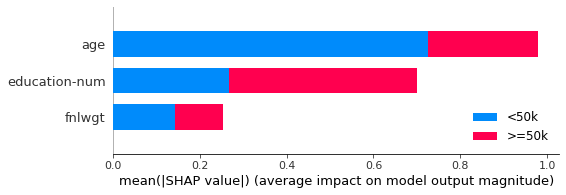

In [0]:
exp.summary_plot()

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted dependent variable as 'Mean_TemperatureC' changes. Vertical dispersion at a single value of 'Mean_TemperatureC' represents interaction effects with other features. To help reveal these interactions `dependence_plot` automatically selects another feature for coloring. In this case coloring by 'Mean_Humidity' highlights that the mean temperature rooms per house has less impact on the dependant variable (SAHP values close to 0) for areas with a humidiy around 0. You can change the interaction variable to visualize trhough the argument `interaction_index="CloudCover"`

Classification model detected, displaying score for the class <50k.
(use `class_id` to specify another class)


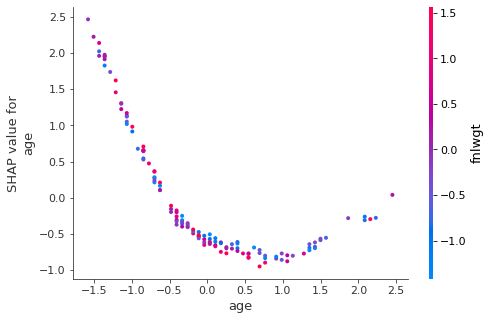

In [0]:
exp.dependence_plot('age', class_id='<50k')

### Confusion matrix

Example of confusion matrix usage to evaluate the quality of the output of a classifier. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

The figures show the confusion matrix with and without normalization by class support size (number of elements in each class). This kind of normalization can be interesting in case of class imbalance to have a more visual interpretation of which class is being misclassified.

![](https://qph.fs.quoracdn.net/main-qimg-d1f717f321a4ebc8e6d2c1d1cc19f9fc)


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

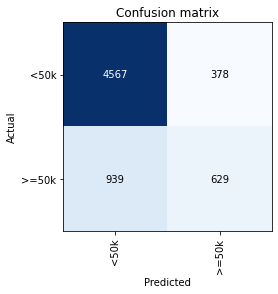

In [0]:
interp.plot_confusion_matrix()

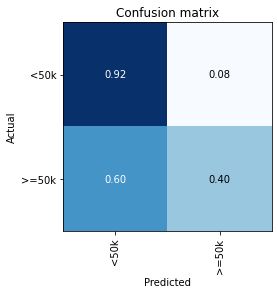

In [0]:
interp.plot_confusion_matrix(normalize=True)

As it can be seen, there is a clear distinction betweeb the performance of the predictions for each class. This can be a result of the imbalance in the class ratio. Class imbalance problem affects the quality and reliability of results in machine learning task and, for this reason, it should be managed by specific techniques and measures of quality.

## Class-imbalaced problems

Imbalance datasets are characterized by a rare class, which represents a small portion of the entire population (1 out of 1000 or 1 out of 10000 or even more). Class imbalance can be intrinsic to the problem, it is imbalanced by its own nature, or it can be determined by the limitation of data collection, caused by economic or privacy reasons.

The minority class is scarce and its own characteristics and own patterns are scarce as well, but those information is extremely important for the trained model to discriminate the small samples from the crowd. Standard classification algorithms, that don’t take into account class distribution, are overwhelmed by the large class and they ignore and misclassify the minority one: there aren’t enough examples to recognize the patterns and the properties of the rare class.

## Evaluation metrics for imbalanced datasets

Accuracy evaluates all the classes as equally important and that’s why it can’t be used as measure of goodness for models working on imbalanced class dataset.
Other metrics are necessary, such as:

* Recall
* Precision
* F1/F2... Measures
* ROC curve and AUC

Which one is better? There isn’t a better metric. It depends on many factors, such as the goal, the context, and the cost function: is it better to classify correctly one more unit of the rare class but, at the same time, increasing False Positive errors (classify no-spam email as spam email), or misclassify some units of the rare class, but decreasing False Positive errors?



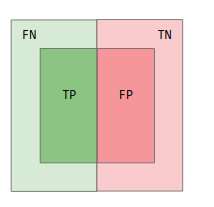

### Penalizing false negatives

Normally, in class imbalanced problems we are interested in reducing the number of false negatives, i.e.: the model says "negative" class, but it is actually "positive", because we don't want to miss the "rare" events, which are encoded as the positive class. **Recall** and **F2** are good examples of metrics that focus on the false negatives.

$$\textit{Recall} = TP/(TP + FN)$$

$$F_{\beta} =  (1+\beta^2)\frac{precision \times recall}{(\beta^2 \times precision)+recall}$$

In [0]:
recall = Recall(pos_label=1)
f2 = FBeta(beta=2, pos_label=1)

Let's re-evaluate our learner based on these metrics

In [0]:
learn.metrics = [accuracy, recall, f2]
[x.name for x in learn.metrics]

['accuracy', 'recall_score', 'fbeta_score']

In [0]:
res = learn.validate()
print(f'accuracy={res[1]}, recall={res[2]}, f2={res[3]}')

accuracy=0.7977890372276306, recall=0.40114795918367346, f2=0.432064844071988


As it can be  seen, the accuracy of the model can be said as "good", but that does not imply that it is a good model for all the cases, specially for the false negative (bad recall and f2)

### Adding weights to the loss function (CrossEntropyLoss)

We can also our loss function to penalize misclassifications of the minority class more than the majority. Pytorch can incorporate different weights in the `CrossEntropyLoss` using the `weights` argument. For the
experiments in this tutorial, we adjust the weights using $w_j = 1/n_j$, where $n_j$ is the population in class j.

In [0]:
from torch.nn import CrossEntropyLoss

In [0]:
_, class_size = np.unique(dls.train.y, return_counts=True)
class_size

array([19775,  6273])

In [0]:
from fastai2.torch_core import *

In [0]:
class_weights = tensor(1/class_size).to('cuda')

In [0]:
wce = CrossEntropyLossFlat(weight=class_weights)

In [0]:
learn_wce = tabular_learner(dls=learn.dls, loss_func=wce, metrics=learn.metrics)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.0005754399462603033)

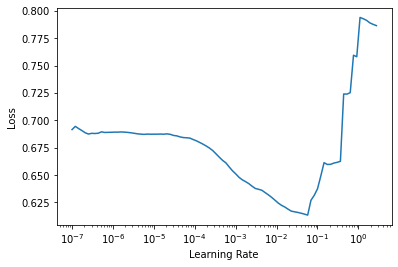

In [0]:
suggested_lrs = learn_wce.lr_find()
suggested_lrs

epoch,train_loss,valid_loss,accuracy,recall_score,fbeta_score,recall_score,fbeta_score,recall_score,fbeta_score,recall_score,fbeta_score,recall_score,fbeta_score,time
0,0.571680,0.540532,0.707508,0.739796,0.649569,0.739796,0.649569,0.739796,0.649569,0.739796,0.649569,0.739796,0.649569,00:00
1,0.553386,0.530915,0.673422,0.825255,0.686909,0.825255,0.686909,0.825255,0.686909,0.825255,0.686909,0.825255,0.686909,00:00
2,0.544648,0.527360,0.675418,0.809311,0.678174,0.809311,0.678174,0.809311,0.678174,0.809311,0.678174,0.809311,0.678174,00:00
3,0.541448,0.527106,0.709043,0.758929,0.662657,0.758929,0.662657,0.758929,0.662657,0.758929,0.662657,0.758929,0.662657,00:00
4,0.537236,0.525535,0.698910,0.779974,0.671167,0.779974,0.671167,0.779974,0.671167,0.779974,0.671167,0.779974,0.671167,00:00


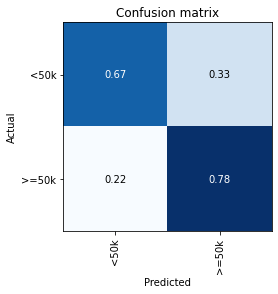

In [0]:
learn_wce.fit_one_cycle(5, lr_max=1e-2)
interp = ClassificationInterpretation.from_learner(learn_wce)
interp.plot_confusion_matrix(normalize=True)

In [0]:
res = learn_wce.final_record
print(f'accuracy={res[1]}, recall={res[2]}, f2={res[3]}')

accuracy=0.6989098787307739, recall=0.7799744897959183, f2=0.6711667215453848


We have achieved better results in the false interested measures! (recall and f2), despite the drop in the general accuracy.

Keep in mind that in a bigger than 90/10 unbalance setting, you will be presenting your network with more than 90 % cases of fairly small losses (weighted by 1/n_samples). While once in a while the other class of less than 10 % will pop up with a huge loss resulting in a relatively huge update step, forcing you to nevertheless stay at a moderate learning rate.

### Undersampling and Oversampling

A well-known approach
to handling class-imbalance is to make our training dataset
balanced. This is often done by undersampling (that is, tak-
ing out instances from the majority class) or oversampling
(that is, providing more instances to the minority class by
replication). 

Undersampling results in using only as many
negative instances (majority) as there are positive instances
(minority) in the training phase, thus achieving a 1:1 balance
ratio. This solution, however, comes at some cost. When
undersampling, we leave out a great portion of the data during
training, therefore not learning from the entire collection. To avoid the enormous data waste, a very large dataset should be available overall.

![](https://miro.medium.com/max/335/1*YH_vPYQEDIW0JoUYMeLz_A.png)

In [0]:
from imblearn.under_sampling import RandomUnderSampler # Find more techniques at https://imbalanced-learn.readthedocs.io/en/stable/api.html
resampling_instance = RandomUnderSampler()
resampling_instance

RandomUnderSampler(random_state=None, ratio=None, replacement=False,
                   return_indices=False, sampling_strategy='auto')

The undersampling and oversampling processors are only taken in the training partition, as undersampling of the validation partition distorts reality and would
not reflect the true model’s performance.

In [0]:
X_train, y_train = dls.train.xs.values, dls.train.y.values
(X_train.shape, y_train.shape)

((12546, 3), (12546,))

In [0]:
X_train_resampled, y_train_resampled = resampling_instance.fit_resample(X_train, y_train)
(X_train_resampled.shape, y_train_resampled.shape)

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


((12546, 3), (12546,))

Check how the size of the training set has been diminished! We can check again the classs imbalanced ratio:

In [0]:
class_counts = np.unique(y_train_resampled, return_counts=True)
class_counts[0], class_counts[1], class_counts[1]/len(y_train_resampled)

(array([0, 1], dtype=int8), array([6273, 6273]), array([0.5, 0.5]))

Now let's replace the training `Dataloader` inside the object `dls` with this new training data.

In [0]:
undersampled_df = pd.DataFrame(X_train_resampled, columns=dls.valid.x_names)
undersampled_df[dls.valid.y_names[0]] = y_train_resampled
undersampled_df

,age,fnlwgt,education-num,salary
0,-1.139608,1.550318,-0.028469,0
1,-0.993090,0.430322,0.364098,0
2,1.131412,-0.167850,1.149232,0
3,0.325566,0.318832,-2.776438,0
4,-1.286125,1.142349,-0.028469,0
...,...,...,...,...
12541,-0.113986,-1.020036,-1.991304,1
12542,0.032532,-0.712050,1.934366,1
12543,-0.993090,0.136732,0.364098,1
12544,-0.187244,1.028904,1.149232,1


In [0]:
dl_train_original = dls.train # keep it in case you want to come back to the original setup later
dls.train.n

12546

In [0]:
dl_train_undersampled = dls.train.new(dls.train.dataset.new(undersampled_df))
dls.train = dl_train_undersampled
dls.train.n

12546

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=1.9054607152938843)

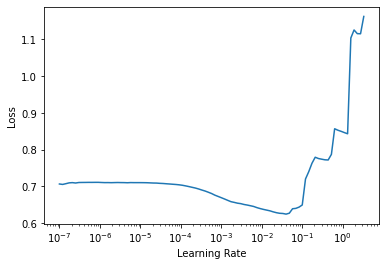

In [0]:
learn_undersampled = tabular_learner(dls, metrics=learn.metrics)
learn_undersampled.lr_find()

epoch,train_loss,valid_loss,accuracy,recall_score,fbeta_score,time
0,0.654438,0.609296,0.713650,0.698980,0.625499,00:00
1,0.593769,0.537285,0.697528,0.757653,0.656354,00:00
2,0.568943,0.547635,0.672041,0.802934,0.672686,00:00
3,0.556434,0.546526,0.669277,0.809949,0.675676,00:00
4,0.548981,0.546786,0.670812,0.812500,0.677948,00:00


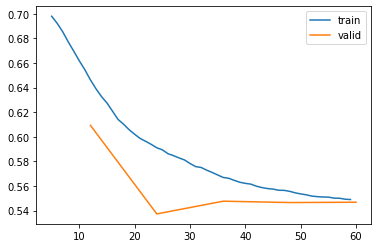

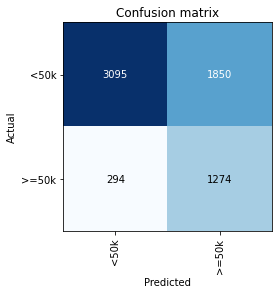

In [0]:
learn_undersampled.fit_one_cycle(n_epoch=5, lr_max=1e-3)
learn_undersampled.recorder.plot_loss()
interp = ClassificationInterpretation.from_learner(learn_undersampled)
interp.plot_confusion_matrix()

In [0]:
res_us = learn_undersampled.final_record
print(f'Original performance: acc= {res[1]}, recall={res[2]}, f2={res[3]}')
print(f'Undersampling performance: acc= {res_us[1]}, recall={res_us[2]}, f2={res_us[3]}')

Original performance: acc= 0.6989098787307739, recall=0.7799744897959183, f2=0.6711667215453848
Undersampling performance: acc= 0.6708122491836548, recall=0.8125, f2=0.6779480630055343


When oversampling, we add replicates of the
existing instances. This may cause a model to memorize the
patterns and structures of minority events in the data instead
of generalizing and learning about them; a bad practice that
is very prone to overfitting.

![image](https://miro.medium.com/max/375/1*aKJJOozIlVVH1gT-4rYy4w.png)

In [0]:
from imblearn.over_sampling import RandomOverSampler # Find more techniques at https://imbalanced-learn.readthedocs.io/en/stable/api.html
os = RandomOverSampler()
os

RandomOverSampler(random_state=None, ratio=None, return_indices=False,
                  sampling_strategy='auto')

In [0]:
dls.train = dl_train_original

In [0]:
X_train, y_train = dls.train.xs.values, dls.train.y.values
(X_train.shape, y_train.shape)

((26048, 3), (26048,))

In [0]:
X_train_os, y_train_os = os.fit_resample(X_train, y_train)
(X_train_os.shape, y_train_os.shape)

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


((39550, 3), (39550,))

In [0]:
class_counts = np.unique(y_train_os, return_counts=True)
class_counts[0], class_counts[1], class_counts[1]/len(y_train_os)

(array([0, 1], dtype=int8), array([19775, 19775]), array([0.5, 0.5]))

In [0]:
df_os = pd.DataFrame(X_train_os, columns=dls.valid.x_names)
df_os[dls.valid.y_names[0]] = y_train_os
df_os

,age,fnlwgt,education-num,salary
0,0.765119,-0.840988,0.756665,1
1,0.398825,0.450162,1.541799,1
2,-0.040727,-0.731089,1.934366,1
3,0.252308,-1.022353,-0.028469,0
4,-0.113986,-0.482319,-1.206170,0
...,...,...,...,...
39545,-0.113986,3.988245,1.149232,1
39546,-0.626797,1.751237,0.364098,1
39547,-0.700055,1.929084,0.364098,1
39548,1.644223,-1.520256,-0.421036,1


In [0]:
dl_train_original = dls.train # keep it in case you want to come back to the original setup later
dls.train.n

26048

In [0]:
dl_train_os = dls.train.new(dls.train.dataset.new(df_os))
dls.train = dl_train_os
dls.train.n

39550

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.0014454397605732083)

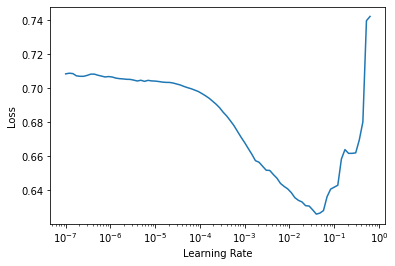

In [0]:
learn_os = tabular_learner(dls, metrics=learn.metrics)
learn_os.lr_find()

epoch,train_loss,valid_loss,accuracy,recall_score,fbeta_score,time
0,0.575081,0.564364,0.658376,0.805485,0.667901,00:00
1,0.551133,0.559983,0.674497,0.814413,0.680849,00:00
2,0.543582,0.528180,0.697374,0.782526,0.672034,00:00
3,0.539901,0.535985,0.705512,0.772321,0.669505,00:00
4,0.536836,0.540985,0.692615,0.792730,0.676131,00:00
5,0.535112,0.522448,0.709351,0.767219,0.668111,00:00
6,0.534472,0.553300,0.671887,0.823980,0.685411,00:00
7,0.532014,0.547793,0.689851,0.805485,0.682703,00:00
8,0.531505,0.544454,0.690465,0.805485,0.682998,00:00
9,0.531096,0.543825,0.692922,0.800383,0.681029,00:00


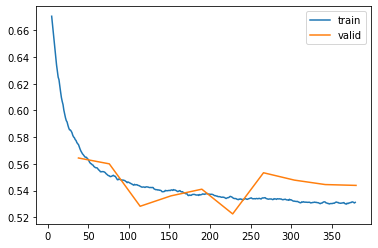

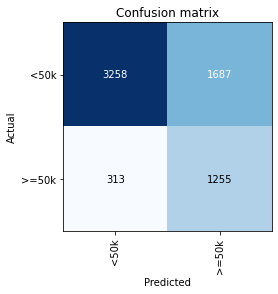

In [0]:
learn_os.fit_one_cycle(n_epoch=10, lr_max=5e-3)
learn_os.recorder.plot_loss()
interp = ClassificationInterpretation.from_learner(learn_os)
interp.plot_confusion_matrix()

In [0]:
res_os = learn_os.final_record
print(f'Original performance: acc= {res[1]}, recall={res[2]}, f2={res[3]}')
print(f'Oversampling performance: acc= {res_os[1]}, recall={res_os[2]}, f2={res_os[3]}')

Original performance: acc= 0.6989098787307739, recall=0.7799744897959183, f2=0.6711667215453848
Oversampling performance: acc= 0.6929218769073486, recall=0.8003826530612245, f2=0.6810288691122206


Our results are not much better in terms of the variables of interest, and there seems to be a bit of overfitting in terms of the validation loss.